# Intra-Annual Sea Level Anomalies
Monthly mean sea level anomalies. This page is very much in development!!

```{caution}
Major updates are needed for this page. Don't look at it too hard...
```


## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. 

In [1]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb

#import tseries functions
from tseries_functions import process_trend_with_nan

### Import the tide gauge data

In [2]:
#import rsl_daily
rsl_daily = xr.open_dataset(data_dir/ 'rsl_daily_hawaii.nc')

#make rsl_daily a subset - do not include TGs with more than 25% NaNs
# get percent Nans in rsl_daily['sea_level']

rsl_daily

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11688)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    latitude      (station_id) float32 28B ...
    longitude     (station_id) float32 28B ...
    lat           (station_id) float64 56B ...
    lon           (station_id) float64 56B ...
    station_name  (station_id) <U27 756B ...
    storm_time    (time) datetime64[ns] 94kB ...
Data variables:
    rsl_anomaly   (station_id, time) float64 655kB ...
    rsl_mhhw      (station_id, time) float64 655kB ...
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

### check the data and drop all stations with less than 80% coverage

In [3]:
data_coverage = rsl_daily.rsl_mhhw.count(dim='time')/len(rsl_daily.time)

#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

rsl_subset

<xarray.Dataset> Size: 1MB
Dimensions:       (station_id: 7, time: 11688)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
  * time          (time) datetime64[ns] 94kB 1993-01-01 ... 2024-12-31
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
    storm_time    (time) datetime64[ns] 94kB ...
Data variables:
    rsl_anomaly   (station_id, time) float64 655kB 0.1267 0.1175 ... -0.0162
    rsl_mhhw      (station_id, time) float64 655kB -0.2623 -0.2715 ... -0.335
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [4]:
# get the record min and max for each TG by month
record_min = rsl_subset.groupby('time.month').min()
record_max = rsl_subset.groupby('time.month').max()

record_min

<xarray.Dataset> Size: 3kB
Dimensions:       (month: 12, station_id: 7)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    rsl_anomaly   (month, station_id) float64 672B -0.1664 -0.2005 ... -0.1009
    rsl_mhhw      (month, station_id) float64 672B -0.5554 -0.375 ... -0.4197
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [5]:
# select which station to plot
station_names = rsl_subset['station_name'].values
station_ids = rsl_subset['station_id'].values

#make a dict
station_dict = dict(zip(station_ids, station_names))
station_dict

{np.str_('1617760'): np.str_('Hilo, Hilo Bay, Kuhio Bay'),
 np.str_('1619910'): np.str_('Sand Island, Midway Islands'),
 np.str_('1617433'): np.str_('Kawaihae'),
 np.str_('1612480'): np.str_('Mokuoloe'),
 np.str_('1615680'): np.str_('Kahului, Kahului Harbor'),
 np.str_('1612340'): np.str_('Honolulu'),
 np.str_('1611400'): np.str_('Nawiliwili')}

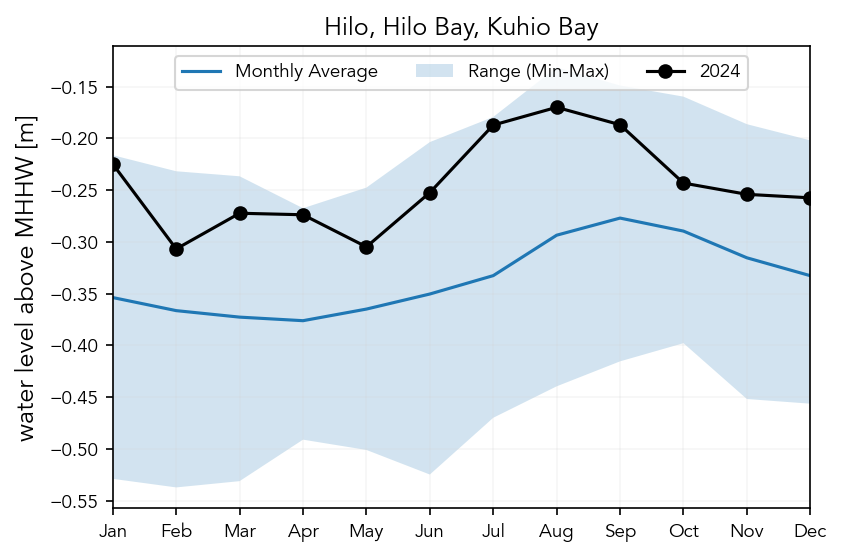

In [6]:
# Resample the data to get monthly means and squeeze any singleton dimensions
rsl_monthly = rsl_subset.resample(time='1MS').mean().squeeze()

# Calculate monthly statistics: mean, minimum, and maximum
epochStart = '1993-01-01'
epochEnd = '2024-12-31'
rsl_monthly_mean = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').mean()
rsl_monthly_min = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').min()
rsl_monthly_max = rsl_monthly.sel(time=slice(epochStart, epochEnd)).groupby('time.month').max()

station_id = station_ids[0]
station_name = station_dict[station_id]

# Plot the average sea level for each month
ax = rsl_monthly_mean['rsl_mhhw'].sel(station_id=station_id).plot(label='Monthly Average')


# Add shaded area between min and max values for each month
plt.fill_between(rsl_monthly_min.month, 
                 rsl_monthly_min['rsl_mhhw'].sel(station_id=station_id), 
                 rsl_monthly_max['rsl_mhhw'].sel(station_id=station_id), 
                 alpha=0.2, label='Range (Min-Max)')




# Add 2024 monthly values on top of the average
rsl_2024 = rsl_monthly.sel(time=slice('2024-01-01', '2024-12-31')).squeeze()
plt.plot(np.arange(1, 13), rsl_2024['rsl_mhhw'].sel(station_id=station_id).values, 
         color='black', label='2024', marker='o')

# Customize the x-axis to show month names instead of numbers
plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set labels and title
# plt.ylabel('Sea Level Anomaly (m)')
plt.xlabel('')
plt.title(rsl_monthly_mean['station_name'].sel(station_id=station_id).values)

# Adjust x-axis limits and add a grid
plt.xlim(1, 12)
# plt.ylim(-0.45, -0.05)
plt.grid(alpha=0.2, color='lightgray')

# Add a legend at the top in 3 columns
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))

# Save the plot to a file
plt.savefig(output_dir / 'SL_MMMA_intra_pacific.png', dpi=300, bbox_inches='tight')

fig = plt.gcf()

glue("SL_MMA_intra",fig,display=False)
glue("station",station_name,display=False)
glue('epochEnd',epochEnd,display=False)
glue('epochStart',epochStart,display=False)


```{glue:figure} SL_MMA_intra
:name: "SL_MMA_intra"

Monthly means at the {glue:text}`station` tide gauge for {glue:text}`epochStart` to {glue:text}`epochEnd`. Note that the sea level is plotted in units of m, relative to MHHW. Note also that this differs from the plot available at https://uhslc.soest.hawaii.edu/stations/?stn=060#climatology, because we are using different periods of record. 
```

````{margin}
```{note}
TO DO: Make relative to MHHW? Add lastest year. Make plot with all TGs on it.
```
````

## Absolute Value: satellite (trend removed)

In [7]:
# open the cmems data
cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2025hawaii.nc')

#reduce to smaller area
cmems = cmems.sel(longitude=slice(180, 210), latitude=slice(15, 32))

### Plot an area-wide map, with stations
First we'll need to make sure that our data is detrended properly in order to look at monthly anomalies.

```{margin}
```{caution}
Come back and check this. Also note: need to add stations on here. #TODO
```
```

In [8]:
# remove long term trend from rsl using polynomial fit
trend_mag_cmems, trend_line_cmems, trend_rate_cmems = process_trend_with_nan(cmems.sla)

cmems_detrended = cmems.sla - trend_line_cmems

# make a cmems monthly mean for plotting
cmems_monthly = cmems_detrended.resample(time='1MS').mean().squeeze()

# get the mean for each month of the year
cmems_climatology = cmems_monthly.groupby('time.month').mean(dim='time')

cmems_mmsla = cmems_monthly.groupby('time.month') - cmems_climatology


Processing xarray DataArray (vectorized polyfit, time in years)...


In [9]:
cmems_climatology_tg = cmems_climatology.interp(longitude=rsl_monthly.longitude, latitude=rsl_monthly.latitude, method='nearest')


In [10]:
cmems_climatology_tg

<xarray.DataArray (month: 12, station_id: 7)> Size: 672B
array([[ 0.00069532, -0.01315398, -0.00097406, -0.00981545, -0.00164283,
        -0.00872945,  0.00056707],
       [-0.01639828, -0.02056177, -0.02304275, -0.02291736, -0.01978056,
        -0.0228284 , -0.02848443],
       [-0.01919085, -0.0180635 , -0.02472998, -0.02641315, -0.02535118,
        -0.02555602, -0.04871308],
       [-0.02971333, -0.01695185, -0.0315438 , -0.02302241, -0.02196353,
        -0.02171302, -0.03679625],
       [-0.01952845, -0.01352931, -0.02291329, -0.02308881, -0.024141  ,
        -0.02305389, -0.02576508],
       [-0.01176222, -0.02339231, -0.0083412 , -0.00570766, -0.00901425,
        -0.00612604, -0.00839809],
       [-0.0101097 , -0.00786871, -0.00586888, -0.00090601, -0.00142759,
        -0.00067445,  0.01959723],
       [ 0.01819317,  0.0229875 ,  0.02116462,  0.01872882,  0.02083892,
         0.0193607 ,  0.02208338],
       [ 0.02898313,  0.03984573,  0.02985695,  0.03307279,  0.03377578,
         0.03193192,  0.03657876],
       [ 0.02660245,  0.02749598,  0.02503151,  0.02921243,  0.02672178,
         0.02932916,  0.03956464],
       [ 0.01911376,  0.01279159,  0.02312231,  0.02298732,  0.0183871 ,
         0.02187968,  0.02485997],
       [ 0.01272477,  0.0089793 ,  0.01782681,  0.0075614 ,  0.00284459,
         0.00569372,  0.00402415]])
Coordinates:
  * month         (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...

Text(0.02, 0.5, 'Monthly Mean Sea Level Anomaly [m]')

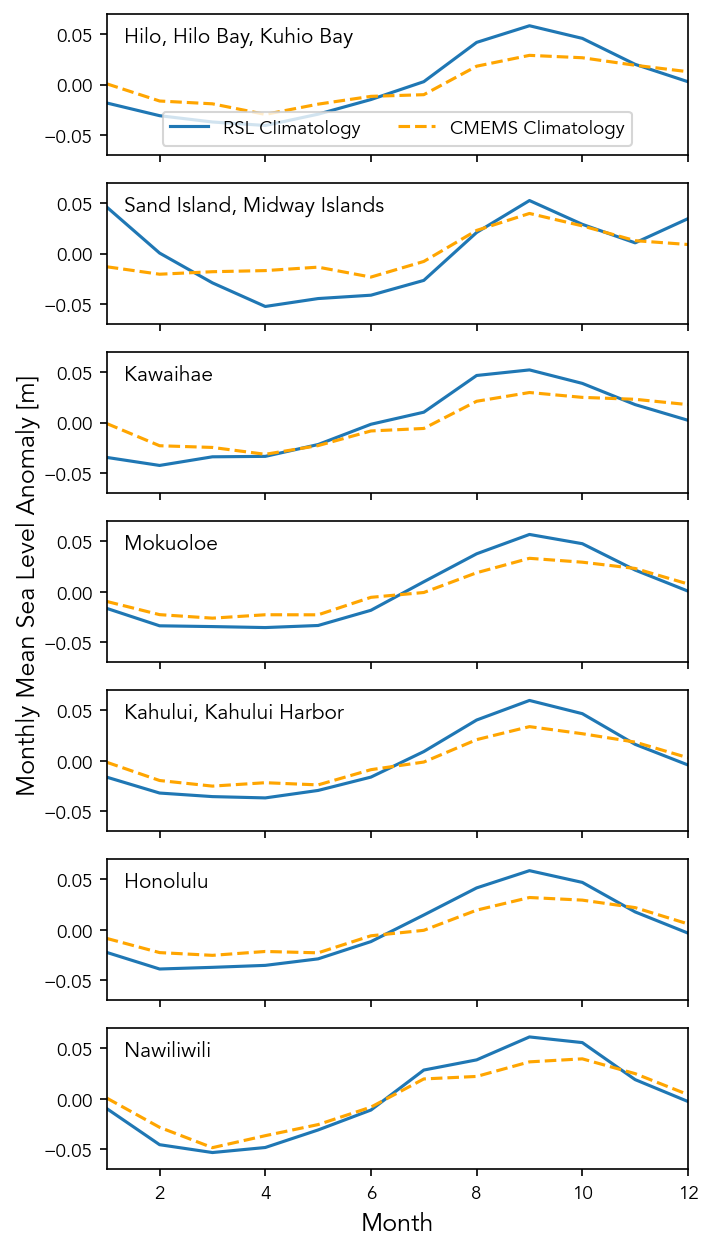

In [12]:
#compare cmems_climatology_tg with rsl_monthly_mean
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(5, 10), sharex=True, sharey=True)
axes = axes.flatten()
# iterate over each axis and plot the monthly mean
for i in range(len(station_ids)):
    ax = axes[i]
    (rsl_monthly_mean['rsl_anomaly'].sel(station_id=station_ids[i])- rsl_monthly_mean['rsl_anomaly'].sel(station_id=station_ids[i]).mean()).plot(ax = ax, x='month',label='RSL Climatology')
    # Add cmems climatology at the station location
    cmems_climatology_tg.sel(station_id=station_ids[i]).plot.line(ax=ax, x='month', label='CMEMS Climatology', color='orange', linestyle='--')

    ax.set_ylim([-0.07,0.07])
    ax.set_xlim([1,12])

    ax.text(0.03,0.8,rsl_monthly['station_name'].values[i], fontsize=10,transform=ax.transAxes)
    ax.set_ylabel(None)
    ax.set_title(None)
    ax.set_xlabel(None)

    if i == 0:
        ax.legend(loc='lower center', ncol=3)   


# add a common x and y label
axes[-1].set_xlabel('Month')
fig.text(0.02, 0.5, 'Monthly Mean Sea Level Anomaly [m]', ha='center', va='center', rotation='vertical')

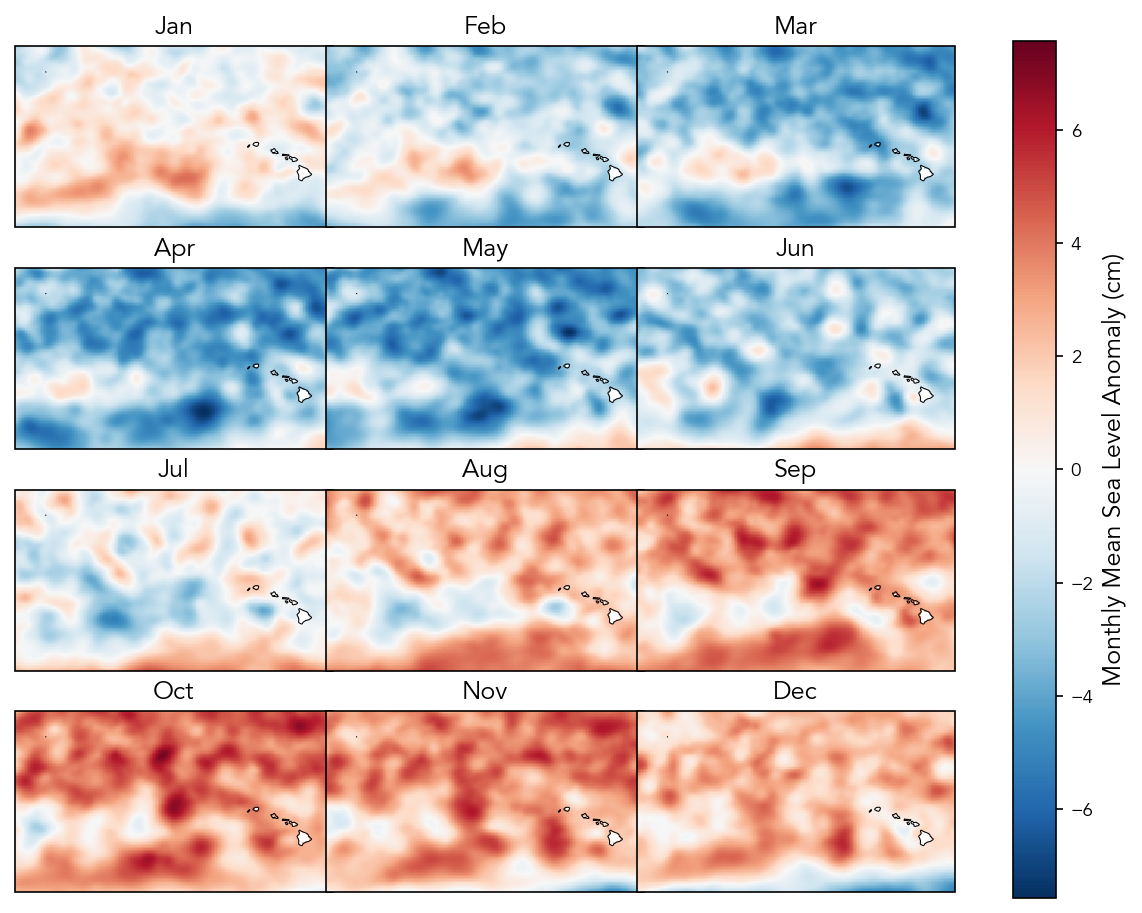

In [16]:
# plot the monthly_anomalies*100 for centimeters
cmems_cm = cmems_climatology * 100



# convert cmems_cm.month to datetime object
months = pd.to_datetime(cmems_cm.month.values, format='%m').strftime('%b')


# Plot the data with modified titles
mma = cmems_cm.plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
                        aspect=cmems_cm.sizes['longitude'] / cmems_cm.sizes['latitude'],
                        subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)},)

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines(linewidth=0.5)
    ax.set_title(months[i])
    ax.set_extent([180, 207,  15, 30]) 

# change the colorbar label
mma.cbar.set_label('Monthly Mean Sea Level Anomaly (cm)')  

#assign mma to a figure
fig = plt.gcf()

# change figure size
fig.set_size_inches(8, 6)

#save the figure
fig.savefig(output_dir / 'SL_anomaly_map_pacific.png', dpi=300)

glue("mma_asl_fig", fig, display=False)



```{glue:figure} mma_asl_fig
:name: "mma-asl-fig"
Map of absolute monthly mean sea level anomalies from altimetry for the full record from {glue:text}`station_group`, {glue:text}`country` station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```


In [17]:
# we can also plot 2024 against the climatology
year = '2023'
yearStart = f'{year}-01-01'
yearEnd = f'{year}-12-31'

cmems_Year = cmems_mmsla.sel(time=slice(yearStart, yearEnd)).squeeze()
# get monthly means
cmems_Year_monthly = cmems_Year.groupby('time.month').mean(dim='time')

cmems_Year_monthly_anomaly = cmems_Year_monthly - cmems_climatology
# plot the monthly_anomalies*100 for centimeters
cmems_Year_cm = cmems_Year_monthly_anomaly * 100


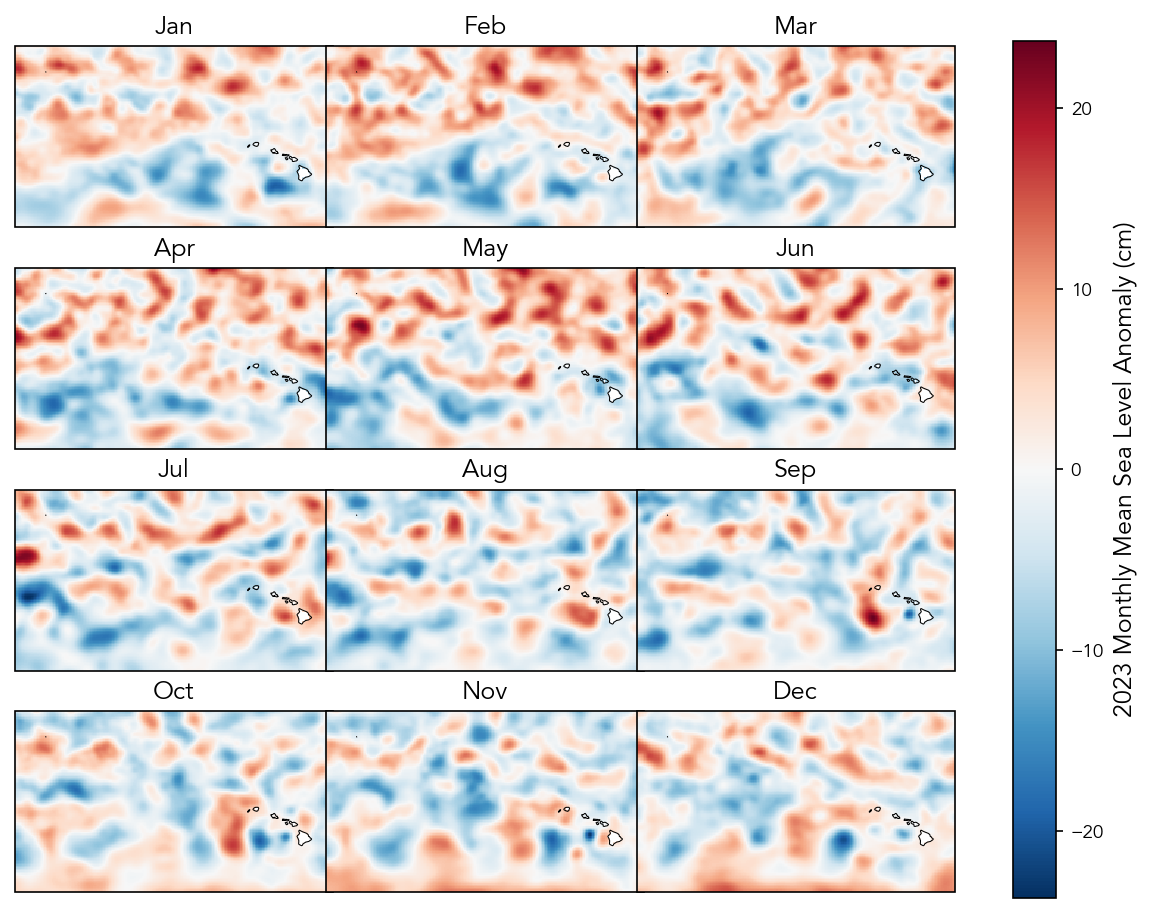

In [18]:
# Plot the data with modified titles
mma = cmems_Year_cm.plot(transform=ccrs.PlateCarree(), col='month', col_wrap=3,
                        aspect=cmems_Year_cm.sizes['longitude'] / cmems_Year_cm.sizes['latitude'],
                        subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)},)

# Add coastlines and land features to each subplot
for i,ax in enumerate(mma.axs.flat):
    ax.coastlines(linewidth=0.5)
    ax.set_title(months[i])
    ax.set_extent([180, 207,  15, 30]) 

# change the colorbar label
mma.cbar.set_label(f'{year} Monthly Mean Sea Level Anomaly (cm)')  

#assign mma to a figure
fig = plt.gcf()

# change figure size
fig.set_size_inches(8, 6)

Let's try that in a movie.

In [31]:
import imageio.v2 as imageio

frames = []
for i, month in enumerate(months):
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(6,3))
    cmems_Year_cm.sel(month=i+1).plot(ax=ax, transform=ccrs.PlateCarree(),vmin=-25, vmax=25, cmap='RdBu_r', cbar_kwargs={'label': f'{year} Monthly Mean \nSea Level Anomaly (cm)'})
    ax.coastlines(linewidth=0.5)
    ax.set_title(month)
    ax.set_extent([180, 207, 15, 30])
    # Save each month as a PNG
    fname = output_dir / f"SL_anomaly_map_pacific_{month}.png"
    fig.savefig(fname, dpi=150)
    frames.append(str(fname))
    plt.close(fig)

# Create GIF from saved PNGs
images = [imageio.imread(frame) for frame in frames]
gif_path = output_dir / "SL_anomaly_map_pacific.gif"
imageio.mimsave(gif_path, images, fps=5, loop=0)


![It's Moving!](https://uhslc.soest.hawaii.edu/jfiedler/SeaLevelIndicators/plotly/SL_anomaly_map_pacific.gif)

## Relative Value: tide station (trend removed)
### area-wide map with stations
### station plots: time series  
These should have ONI/ENSO phase included on them

In [ ]:
rsl_monthly

<xarray.Dataset> Size: 47kB
Dimensions:       (time: 384, station_id: 7)
Coordinates:
  * station_id    (station_id) <U7 196B '1617760' '1619910' ... '1611400'
    latitude      (station_id) float32 28B 19.69 28.19 20.06 ... 21.31 21.94
    longitude     (station_id) float32 28B 204.9 182.7 204.2 ... 202.2 200.7
    lat           (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon           (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    station_name  (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... 'Naw...
  * time          (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2024-12-01
Data variables:
    rsl_anomaly   (time, station_id) float64 22kB 0.03216 -0.006055 ... 0.1083
    rsl_mhhw      (time, station_id) float64 22kB -0.3568 -0.1805 ... -0.2105
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

In [ ]:
# remove long-term trend from rsl_monthly
trend_mag_rsl, trend_line_rsl, trend_rate_rsl = process_trend_with_nan(rsl_monthly.rsl_anomaly)

rsl_monthly_detrended = rsl_monthly.rsl_anomaly - trend_line_rsl

# add detrended rsl_monthly to rsl_monthly
rsl_monthly['sea_level_detrended'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended'].attrs = {'long_name': 'sea level anomaly', 'units': 'm'}

In [ ]:
# remove annual cycle from rsl_monthly
rsl_monthly_detrended = rsl_monthly_detrended.groupby('time.month') - rsl_monthly_detrended.groupby('time.month').mean(dim='time')

# add to rsl_monthly
rsl_monthly['sea_level_detrended_anom'] = rsl_monthly_detrended
rsl_monthly['sea_level_detrended_anom'].attrs = {'long_name': 'monthly mean sea level anomaly', 'units': 'm'}

## Make a plot

In [ ]:
rsl_monthly.sel(station_id=station_id)

<xarray.Dataset> Size: 19kB
Dimensions:                   (time: 384)
Coordinates:
    station_id                <U7 28B '1617760'
    latitude                  float32 4B 19.69
    longitude                 float32 4B 204.9
    lat                       float64 8B 19.73
    lon                       float64 8B 204.9
    station_name              <U27 108B 'Hilo, Hilo Bay, Kuhio Bay'
  * time                      (time) datetime64[ns] 3kB 1993-01-01 ... 2024-1...
    month                     (time) int64 3kB 1 2 3 4 5 6 7 ... 7 8 9 10 11 12
Data variables:
    rsl_anomaly               (time) float64 3kB 0.03216 0.01531 ... 0.1315
    rsl_mhhw                  (time) float64 3kB -0.3568 -0.3736 ... -0.2575
    sea_level_detrended       (time) float64 3kB 0.03603 0.01888 ... 0.02057
    sea_level_detrended_anom  (time) float64 3kB 0.05275 0.04853 ... 0.01946
Attributes:
    units:      m
    long_name:  Sea Level Anomaly
    epoch:      1993-2012

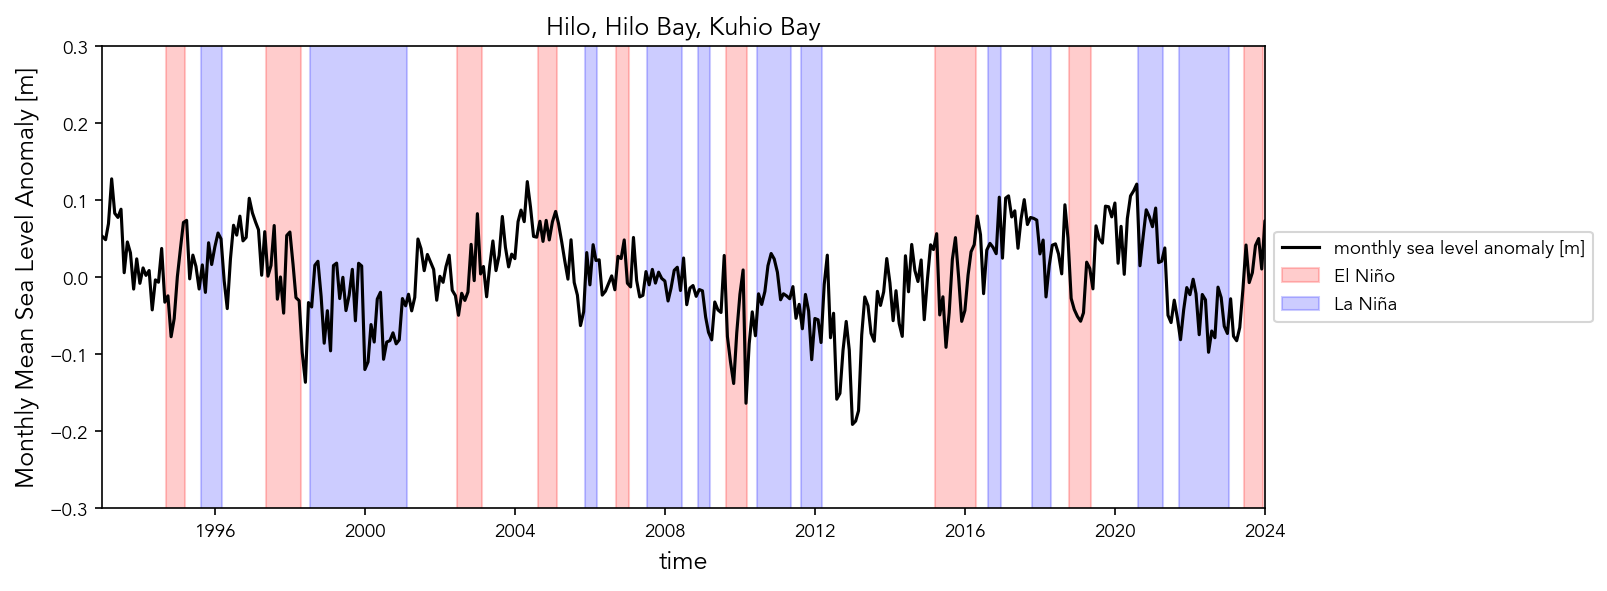

In [ ]:
# get axis for the plots
fig,ax = plt.subplots(1,1,figsize=(10,4), sharex=True, sharey=True)

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices'/'oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )



rsl_monthly['sea_level_detrended_anom'].sel(station_id=station_id).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black')
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')
# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])
ax.set_title(rsl_monthly['station_name'].sel(station_id=station_id).values)
ax.set_ylabel('Monthly Mean Sea Level Anomaly [m]')

 #put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#save the figure
# fig.savefig(output_dir / 'SL_anomaly_timseries_pacific.png', dpi=300)
# glue("SL_anomaly_timeseries_honolulu_fig", fig, display=False)

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_74579/3128050113.py:35: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



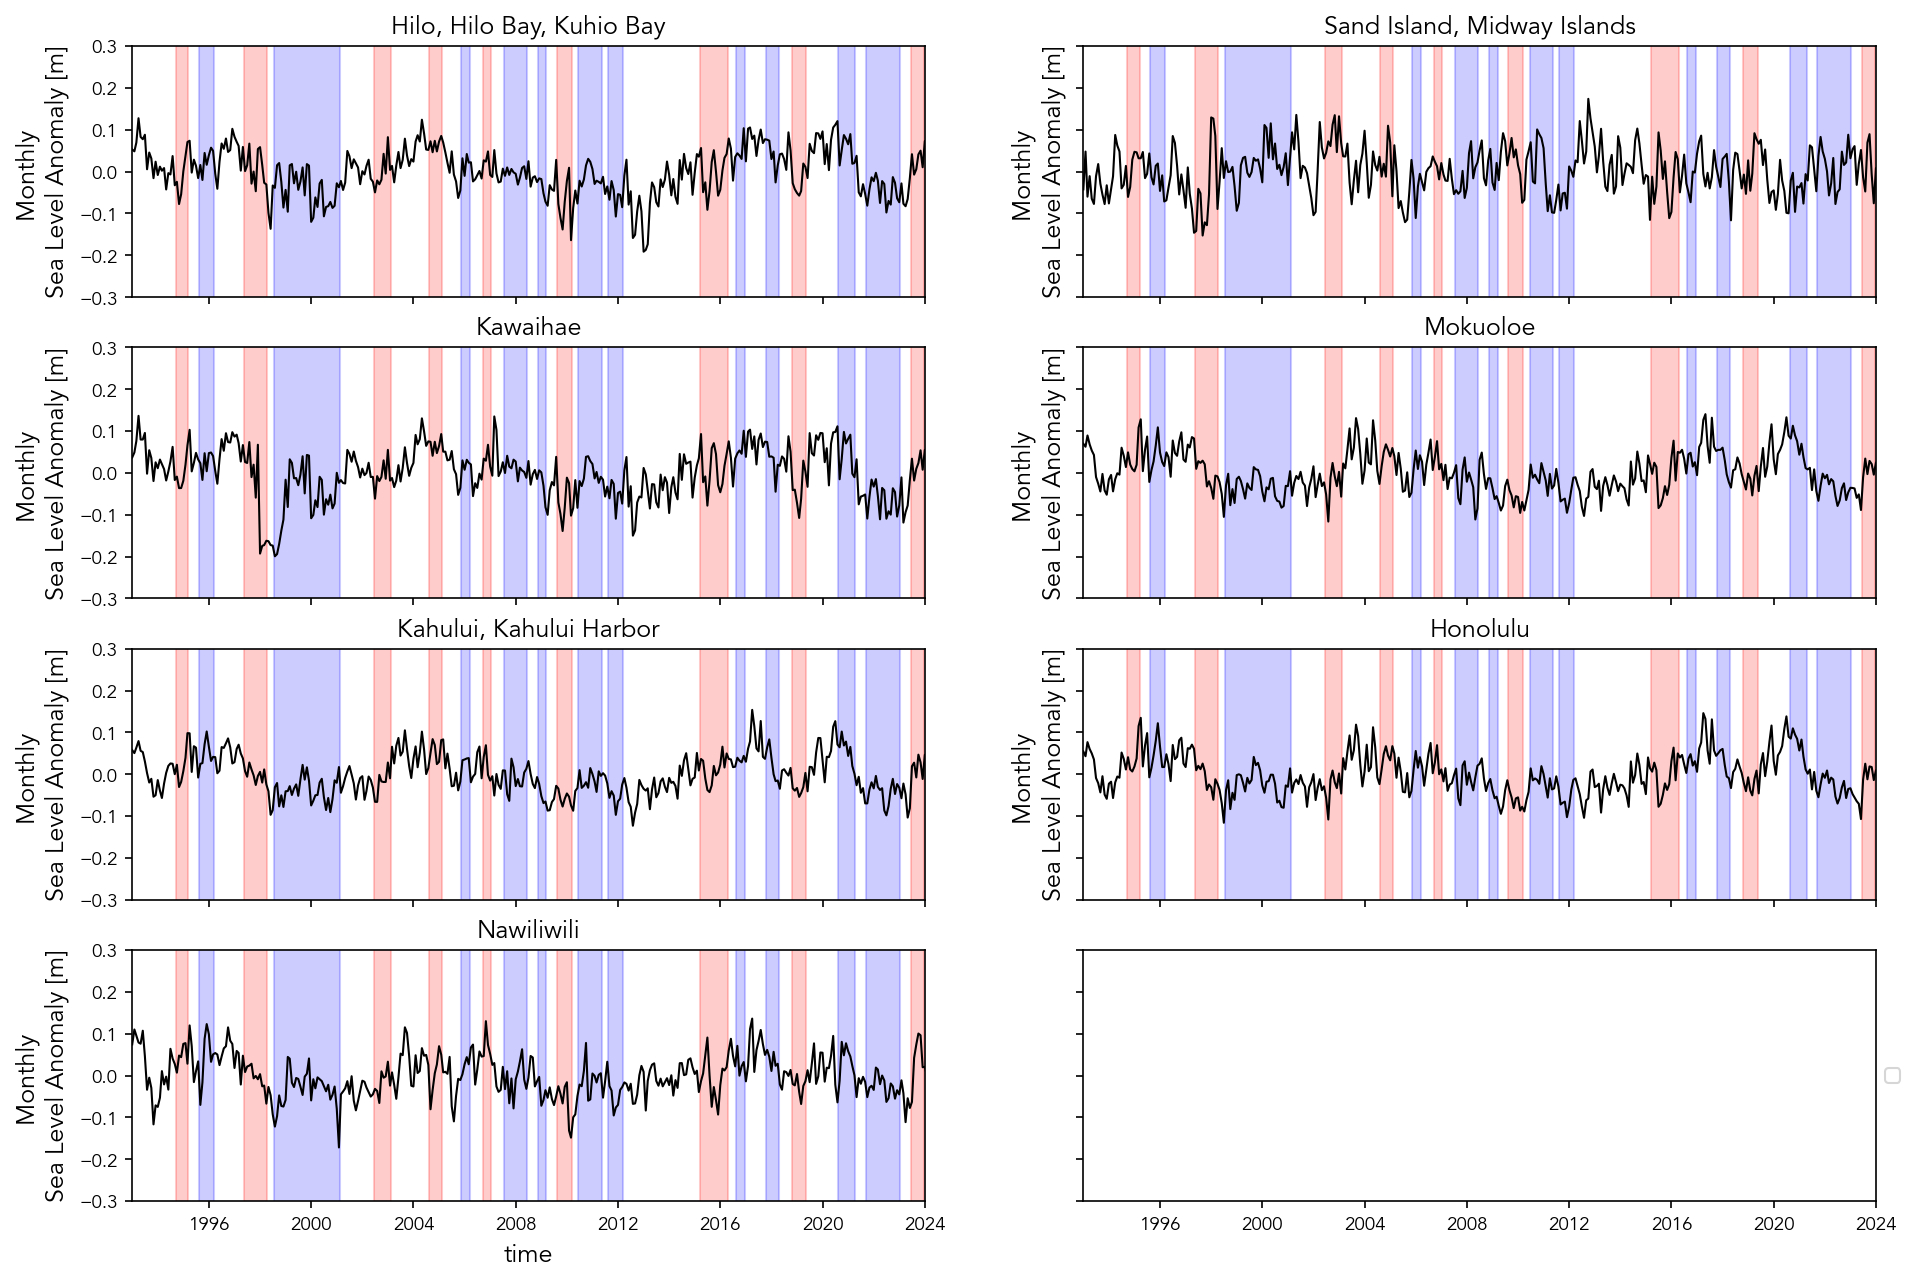

In [ ]:

# get axis for the plots
fig,axes = plt.subplots(4,2,figsize=(15,10), sharex=True, sharey=True)
axes = axes.flatten()

# add ENSO to the plots
# import oni.csv
oni = pd.read_csv(data_dir/'climate_indices'/'oni_bool.csv',header=0)
# change oni index to Date column
oni.index = pd.to_datetime(oni['Date'] )


# iterate over each axis and plot the monthly mean
for i in range(len(station_ids)):
    ax = axes[i]
    rsl_monthly['sea_level_detrended_anom'].sel(station_id=station_ids[i]).plot.line(ax=ax, x='time', label='monthly sea level anomaly [m]', color='black',linewidth=1)

    # Shading El Niño events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

    # Shading La Niña events
    ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                    where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')
    
    ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
    ax.set_ylim([-0.3,0.3])

    ax.set_title(rsl_monthly['station_name'].values[i])
    ax.set_ylabel('Monthly \nSea Level Anomaly [m]')

    if i < 6:
        ax.set_xlabel('')

#put legend on the side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save the figure
fig.savefig(output_dir / 'SL_anomaly_timseries_stations.png', dpi=300)

glue("SL_anomaly_timeseries_stations_fig", fig, display=False)


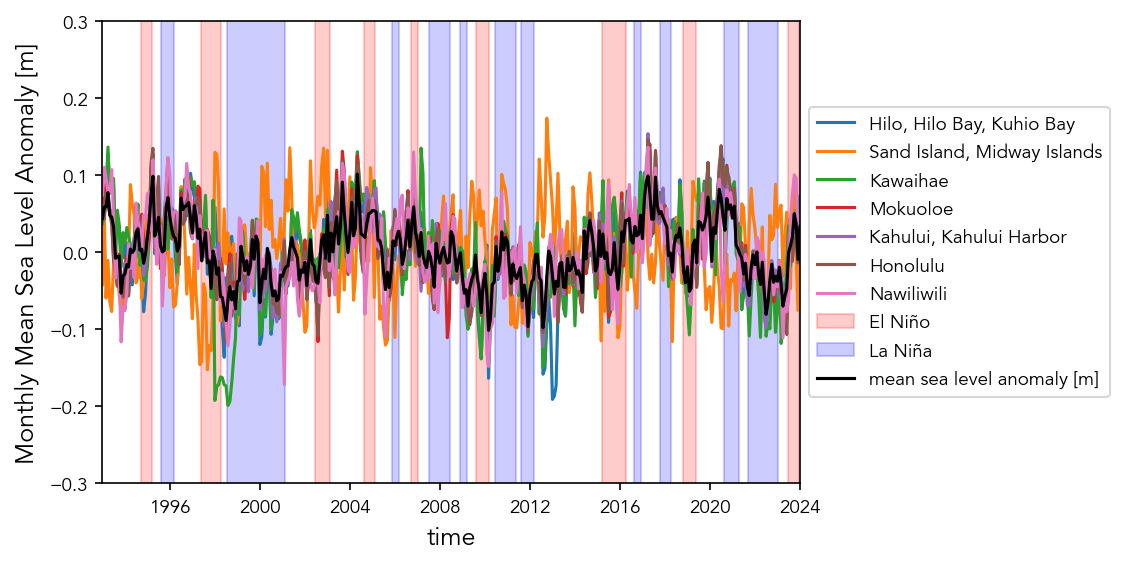

In [ ]:
# make the same plot but only on one axis
fig,ax = plt.subplots()


rsl_monthly['sea_level_detrended_anom'].plot.line(x='time', label=rsl_monthly['station_name'].values)

# add ONI shading
# Shading El Niño events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['El Nino'] == 1, color='red', alpha=0.2, label='El Niño')

# Shading La Niña events
ax.fill_between(oni.index, oni['ONI'].min(), oni['ONI'].max(), 
                where=oni['La Nina'] == 1, color='blue', alpha=0.2, label='La Niña')

ax.set_xlim([dt.datetime(1993,1,1),dt.datetime(2024,1,1)])
ax.set_ylim([-0.3,0.3])

#put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Monthly Mean Sea Level Anomalies (1993-2023)')

# add mean sea level anomaly to the plot
rsl_monthly['sea_level_detrended_anom'].mean(dim='station_id').plot.line(x='time', label='mean sea level anomaly [m]', color='black')

#update the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# change ylabel
ax.set_ylabel('Monthly Mean Sea Level Anomaly [m]')

#save the figure
fig.savefig(output_dir / 'SL_anomaly_timeseries.png', dpi=300)

glue("SL_anomaly_timeseries_fig", fig, display=False)


```{glue:figure} SL_anomaly_timeseries_fig
:name: "SL_anomaly_timeseries"
Plot of absolute monthly mean sea level anomalies from tide gauges for the full record from the Hawaiian Island region stations, station from {glue:text}`startDateTime` to {glue:text}`endDateTime`.
```
